In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import regex as re

Starting with looking at just the ZEV Sales dataset and copying over the cleaning done from last time.

In [84]:
zev_sales = pd.read_csv('Data/zev_sales.csv')

zev_sales = zev_sales[(zev_sales['Data Year'] <= 2021) & (zev_sales['Data Year'] >= 2009)]

zev_sales.head()

,Data Year,County,FUEL_TYPE,MAKE,MODEL,Number of Vehicles
19,2009,Alameda,Electric,Tesla,Roadster,5
20,2009,Contra Costa,Electric,Tesla,Roadster,1
21,2009,Humboldt,Electric,Ford,Ranger,1
22,2009,Kern,Electric,Tesla,Roadster,1
23,2009,Los Angeles,Electric,MINI,Cooper,6


Let's see how many cars are sold per year, and if that number is increasing.

Data Year
2009        84
2010       661
2011      6743
2012     17839
2013     39805
2014     58663
2015     64134
2016     72683
2017     93587
2018    157143
2019    147347
2020    145099
2021    250279
Name: Number of Vehicles, dtype: int64

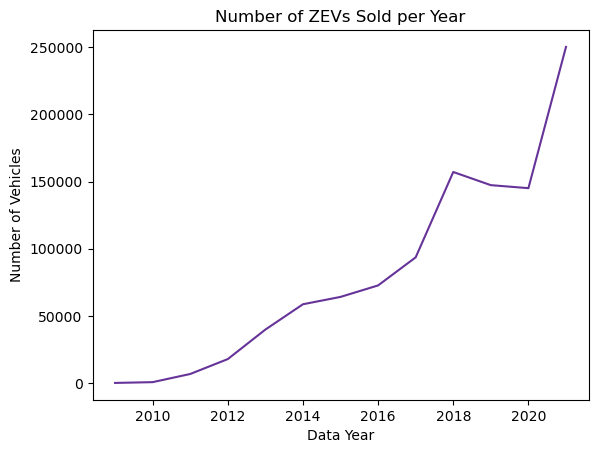

In [126]:
sns.lineplot(data = zev_sales.groupby('Data Year').sum(), x = 'Data Year', 
                    y = 'Number of Vehicles', color = 'rebeccapurple');
plt.title('Number of ZEVs Sold per Year');

zev_sales.groupby('Data Year').sum()['Number of Vehicles']

It looks like the sales of ZEVs in California has increased over time! It looks like there could potentially be a linear correlation between the number of years and the number of ZEVs sold. We now run a linear regression to see if this is the case. 

In [4]:
zev_sales['Data Year'] = zev_sales['Data Year'].astype(int) - 2009
zev_sales['Number of Vehicles'] = zev_sales['Number of Vehicles'].astype(int)

# print(sm.OLS(zev_sales['Number of Vehicles'], zev_sales['Data Year']).fit().summary())

# see that our coefficient is 0.0420, so that times some year would give us some amount of cars sold that year
# may not keep this however, since i cant find the intercept 
# also this is with the calendar years 2009, 2010, etc. we could also do it as number of years since 2009


Which counties have the highest amount of ZEV sales?

Let's also make a bar graph of the number of sales for the top 10 counties. 


In [5]:
# sns.barplot(data = zev_sales.groupby('County').sum().sort_values(by = 'Number of Vehicles', 
#                 ascending = False).head(10).reset_index(), x = 'County', y = 'Number of Vehicles', 
#                    color = 'rebeccapurple')
# plt.xticks(rotation=45)
# plt.title('Top 10 Counties ZEV Sales')

# zev_sales.groupby('County').sum().sort_values(by = 'Number of Vehicles', ascending = False).head(10)


This makes sense, intuitively. These counties are [the most populous](https://www.california-demographics.com/counties_by_population) as well. What is the cumulative number of sales per year? (i.e. if one car is sold year one, and two are sold year two, the cumulative number of sales by year two would be three.) 

We will also break it down by sales since X year, which will make it easier for us to compare with the amount of registrations some year.

In [54]:
by_year = zev_sales.groupby('Data Year').sum()

count_per_year = by_year['Number of Vehicles'].values

sum09 = []
sum10 = []
sum11 = []
sum12 = []
sum13 = []
sum14 = []
sum15 = []
sum16 = []
sum17 = []
sum18 = []
sum19 = []
sum20 = []
sum21 = []

for i in range(len(count_per_year)):
    sum09.append(sum(count_per_year[0:i + 1]))
    sum10.append(sum(count_per_year[1:i + 1]))
    sum11.append(sum(count_per_year[2:i + 1]))
    sum12.append(sum(count_per_year[3:i + 1]))
    sum13.append(sum(count_per_year[4:i + 1]))
    sum14.append(sum(count_per_year[5:i + 1]))
    sum15.append(sum(count_per_year[6:i + 1]))
    sum16.append(sum(count_per_year[7:i + 1]))
    sum17.append(sum(count_per_year[8:i + 1]))
    sum18.append(sum(count_per_year[9:i + 1]))
    sum19.append(sum(count_per_year[10:i + 1]))
    sum20.append(sum(count_per_year[11:i + 1]))
    sum21.append(sum(count_per_year[12:i + 1]))
 
    
by_year['Sales Since 2009'] = sum09
by_year['Sales Since 2010'] = sum10
by_year['Sales Since 2011'] = sum11
by_year['Sales Since 2012'] = sum12
by_year['Sales Since 2013'] = sum13
by_year['Sales Since 2014'] = sum14
by_year['Sales Since 2015'] = sum15
by_year['Sales Since 2016'] = sum16
by_year['Sales Since 2017'] = sum17
by_year['Sales Since 2018'] = sum18
by_year['Sales Since 2019'] = sum19
by_year['Sales Since 2020'] = sum20
by_year['Sales Since 2021'] = sum21


# print('The total number of ZEVs sold between 2009 and 2021 is ' + str(sum(count_per_year)))

by_year

The total number of ZEVs sold between 2009 and 2021 is 1054067


,Number of Vehicles,Sales Since 2009,Sales Since 2010,Sales Since 2011,Sales Since 2012,Sales Since 2013,Sales Since 2014,Sales Since 2015,Sales Since 2016,Sales Since 2017,Sales Since 2018,Sales Since 2019,Sales Since 2020,Sales Since 2021
Data Year,,,,,,,,,,,,,,
2009,84,84,0,0,0,0,0,0,0,0,0,0,0,0
2010,661,745,661,0,0,0,0,0,0,0,0,0,0,0
2011,6743,7488,7404,6743,0,0,0,0,0,0,0,0,0,0
2012,17839,25327,25243,24582,17839,0,0,0,0,0,0,0,0,0
2013,39805,65132,65048,64387,57644,39805,0,0,0,0,0,0,0,0
2014,58663,123795,123711,123050,116307,98468,58663,0,0,0,0,0,0,0
2015,64134,187929,187845,187184,180441,162602,122797,64134,0,0,0,0,0,0
2016,72683,260612,260528,259867,253124,235285,195480,136817,72683,0,0,0,0,0
2017,93587,354199,354115,353454,346711,328872,289067,230404,166270,93587,0,0,0,0


We can also look at ZEV sales as a percentage of cars registered by county in 2021. We will perform the same data cleaning steps but only on the 2021 registration data. 

In [7]:
reg_2021 = pd.read_csv('Data/Vehicles Registered By County-2021.csv', encoding='utf-16')
reg_2021 = reg_2021.dropna().iloc[0:59].drop(columns=['Trailers', 'Motorcycles'])
reg_2021['Total Vehicles'] = reg_2021['Autos'] + reg_2021['Trucks']


Now we prepare to merge datasets. This dataset will contain information about the number of automobiles and ZEVs sold between 2009 and 2021. Given the average age of a car is 12 years, we assume that a car sold in 2009 is still registered in 2021 (hence why we filtered the `zev_sales` dataset to between 2009 and 2021), so we will only be looking at registrations in 2021. 

In [8]:
reg_2021['Counties'] = reg_2021['Counties'].apply(str.lower)
reg_2021.sort_values(by = 'Counties', inplace = True)

by_county = zev_sales.groupby('County').sum().sort_values(by = 'County').reset_index()
by_county['County'] = by_county['County'].apply(str.lower)

merged = reg_2021.merge(by_county, left_on = 'Counties', right_on = 'County').drop(['County', 
                        'Data Year', 'Trucks', 'Total Vehicles'], axis = 1)

merged = merged.rename(columns = {'Counties': 'County', 'Number of Vehicles': 'Number of ZEVs'})

merged['Percentage ZEV'] = (merged['Number of ZEVs'] * 100) / merged['Autos']

merged.sort_values(by = 'Percentage ZEV', ascending = False).head(10)

,County,Autos,Number of ZEVs,Percentage ZEV
43,santa clara,1332612.0,131768,9.887949
30,out of state,109678.0,9716,8.858659
20,marin,190777.0,16011,8.392521
0,alameda,1055138.0,77064,7.303689
38,san francisco,393078.0,28370,7.217397
41,san mateo,569797.0,41111,7.215026
29,orange,2271305.0,132189,5.819958
6,contra costa,824951.0,40854,4.952294
18,los angeles,6386830.0,281524,4.407883
44,santa cruz,176886.0,7621,4.308425


Again, we will plot the top ten counties with the highest ZEV sales by percentage in a bar plot.

In [9]:
# fig, axes = plt.subplots(figsize = (10,5))
# fig.tight_layout()

# plt.subplot(1, 2, 1)
# sns.barplot(data = merged.sort_values(by = 'Percentage ZEV', ascending = False).head(10), x = 'County', 
#             y = 'Percentage ZEV', color = 'rebeccapurple');
# plt.xticks(rotation=45);
# plt.title('Top 10 Counties ZEV Sales (Percentage)');

# plt.subplot(1, 2, 2)
# sns.barplot(data = zev_sales.groupby('County').sum().sort_values(by = 'Number of Vehicles', 
#                 ascending = False).head(10).reset_index(), x = 'County', y = 'Number of Vehicles', 
#                    color = 'rebeccapurple');
# plt.xticks(rotation=45);
# plt.title('Top 10 Counties ZEV Sales');


We see that the the counties with the highest ZEV sales do not necessarily correspond with the highest percentage of ZEV sales. <p>
    
Registration data starts in 2008, zev_sales data starts in 1998. Starting with registration data from 2008 would imply that the average car registered in 2008 was sold in 1996, which we don't have data for. So we start with registration data in 2010. The average age of a car registered in 2010 will be 12 years approximately, and will have been sold in 1998, which we do have sales data for. We will re-import our dataframe with the sales years limited to between 1998 and 2021. <p>

In [123]:
zev_full = pd.read_csv('Data/zev_sales.csv')

zev_full = zev_full[zev_full['Data Year'] <= 2021]

by_year_full = zev_full.groupby('Data Year').sum()

by_year_full.loc[2007] = 0
by_year_full.loc[2008] = 0

by_year_full = by_year_full.reset_index().sort_values(by = 'Data Year').set_index('Data Year')


sold_within_12_years = []

for i in range(2010, 2022):
    sold_within_12_years.append(sum(by_year_full.loc[i - 12: i]['Number of Vehicles']))
    

# i am only using the registration data from 2010 and onwards. this may cause other issues. ask sophia to drop 2008 and 2009 if theyre not needed? or i can also rename my own set.

In [120]:
reg_2010 = pd.read_csv('Data/Vehicles Registered By County-2010.csv', encoding='utf-16')
reg_2011 = pd.read_csv('Data/Vehicles Registered By County-2011.csv', encoding='utf-16')
reg_2012 = pd.read_csv('Data/Vehicles Registered By County-2012.csv', encoding='utf-16')
reg_2013 = pd.read_csv('Data/Vehicles Registered By County-2013.csv', encoding='utf-16')
reg_2014 = pd.read_csv('Data/Vehicles Registered By County-2014.csv', encoding='utf-16')
reg_2015 = pd.read_csv('Data/Vehicles Registered By County-2015.csv', encoding='utf-16')
reg_2016 = pd.read_csv('Data/Vehicles Registered By County-2016.csv', encoding='utf-16')
reg_2017 = pd.read_csv('Data/Vehicles Registered By County-2017.csv', encoding='utf-16')
reg_2018 = pd.read_csv('Data/Vehicles Registered By County-2018.csv', encoding='utf-16')
reg_2019 = pd.read_csv('Data/Vehicles Registered By County-2019.csv', encoding='utf-16')
reg_2020 = pd.read_csv('Data/Vehicles Registered By County-2020.csv', encoding='utf-16')
reg_2021 = pd.read_csv('Data/Vehicles Registered By County-2021.csv', encoding='utf-16')
reg_2021 = pd.read_csv('Data/Vehicles Registered By County-2021.csv', encoding='utf-16')

all_sets = [reg_2010, reg_2011, reg_2012, reg_2013, reg_2014, reg_2015, reg_2016, 
            reg_2017, reg_2018, reg_2019, reg_2020, reg_2021]

year = 2010
for df in all_sets:
    df['Year'] = year
    year += 1;
    
registrations = pd.concat(all_sets).reset_index(drop = True)

registrations = registrations.dropna()
registrations = registrations[registrations.Counties != 'FEE EXEMPT VEHICLES'][registrations.Counties != 'IRP VEHICLES*'][registrations.Counties != 'MISC VEHICLES'][registrations.Counties != 'STATEWIDE']

registrations = registrations.drop(columns=['Trailers', 'Motorcycles'])
registrations['Total Vehicles'] = registrations['Autos'] + registrations['Trucks']

registrations_by_year = registrations.groupby('Year').sum()

/var/folders/0m/xh6cm8vn0l14rdl0zn854rmh0000gp/T/ipykernel_17735/3961635115.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  registrations = registrations[registrations.Counties != 'FEE EXEMPT VEHICLES'][registrations.Counties != 'IRP VEHICLES*'][registrations.Counties != 'MISC VEHICLES'][registrations.Counties != 'STATEWIDE']


In [121]:
registrations_by_year['ZEV Sales Within Past 12 Years'] = sold_within_12_years

registrations_by_year['Percentage ZEV'] = (registrations_by_year['ZEV Sales Within Past 12 Years'] / registrations_by_year['Total Vehicles']) * 100

registrations_by_year

,Autos,Trucks,Total Vehicles,ZEV Sales Within Past 12 Years,Percentage ZEV
Year,,,,,
2010,22040779.0,5711052.0,27751831.0,773,0.002785
2011,22083049.0,5561453.0,27644502.0,7511,0.027170
2012,22473717.0,5530290.0,28004007.0,25349,0.090519
2013,23237523.0,5584074.0,28821597.0,65152,0.226053
2014,23805920.0,5591533.0,29397453.0,123814,0.421173
2015,24487807.0,5648187.0,30135994.0,187945,0.623656
2016,25244537.0,5812320.0,31056857.0,260622,0.839177
2017,25467663.0,5850286.0,31317949.0,354208,1.131006
2018,25646228.0,5890475.0,31536703.0,511343,1.621422


Text(0.5, 1.0, 'Percentage of ZEV Cars on the Road by Year')

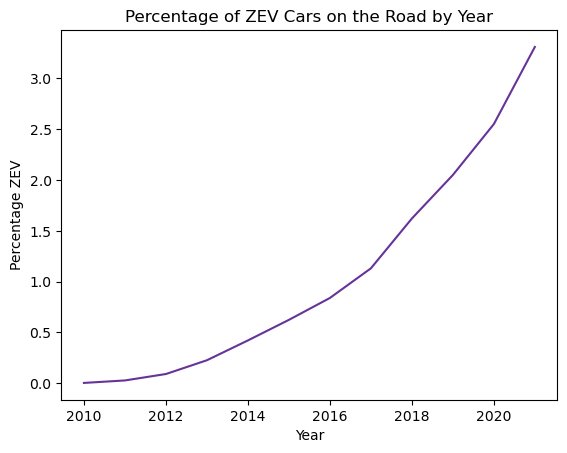

In [127]:
sns.lineplot(data = registrations_by_year, x = 'Year', y = 'Percentage ZEV', color = 'rebeccapurple');
plt.title('Percentage of ZEV Cars on the Road by Year')
